Brief description of the problem and data

The text discusses the intersection of art and technology, focusing on how generative adversarial networks (GANs) can replicate the distinct styles of artists like Claude Monet. It highlights the advancements in computer vision that enabled the creation of original paintings or enhanced photos in Monet's style. The project encourages exploration of whether these data science techniques can produce artworks that classifiers might mistake for genuine Monet pieces, posing an exciting challenge.

In [1]:
# import zipfile

# with zipfile.ZipFile('/workspaces/GANs-coursera/data/gan-getting-started.zip', 'r') as zip_ref:
#     zip_ref.extractall('/workspaces/GANs-coursera/data/')

In [2]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import (Dense, Reshape, Flatten, Dropout, BatchNormalization,
                                     Conv2D, Conv2DTranspose, LeakyReLU, ReLU)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Input

2024-12-01 17:02:34.848760: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 17:02:34.878651: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 17:02:34.894212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733072554.912507   36877 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733072554.916915   36877 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 17:02:34.958717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS: 1


In [4]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1

In [5]:
monet_tfrec_directory = '/workspaces/GANs-coursera/data/gan-getting-started/monet_tfrec'
photo_tfrec_directory = '/workspaces/GANs-coursera/data/gan-getting-started/photo_tfrec'
monet_jpg_directory = '/workspaces/GANs-coursera/data/gan-getting-started/monet_jpg'
photo_jpg_directory = '/workspaces/GANs-coursera/data/gan-getting-started/photo_jpg'
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names
monet_images_path = getImagePaths(monet_jpg_directory)
photo_images_path = getImagePaths(photo_jpg_directory)
monet_tfrec_path = getImagePaths(monet_tfrec_directory)
photo_tfrec_path = getImagePaths(photo_tfrec_directory)
print(f"Number of Monet images: {len(monet_jpg_directory)}\n")
print(f"Number of Photo images: {len(photo_jpg_directory)}\n")
print(f"Number of Monet tfrec: {len(monet_tfrec_directory)}\n")
print(f"Number of Photo tfrec: {len(photo_tfrec_directory)}\n")

Number of Monet images: 60

Number of Photo images: 60

Number of Monet tfrec: 62

Number of Photo tfrec: 62



In [6]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))  # Changed from 256x256
    img_array = img_to_array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    return img_array

images = np.array([load_and_preprocess_image(img) for img in monet_images_path])
print(f'Images shape: {images.shape}')

Images shape: (300, 128, 128, 3)


In [7]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [9]:
monet_ds = load_dataset(monet_tfrec_path, labeled=True).batch(100, drop_remainder=True)
photo_ds = load_dataset(photo_tfrec_path, labeled=True).batch(100, drop_remainder=True)

2024-12-01 17:02:38.979951: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


2024-12-01 17:02:39.191763: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2024-12-01 17:02:39.208658: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2024-12-01 17:02:39.299097: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.


2024-12-01 17:02:39.559152: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2024-12-01 17:02:39.632353: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.


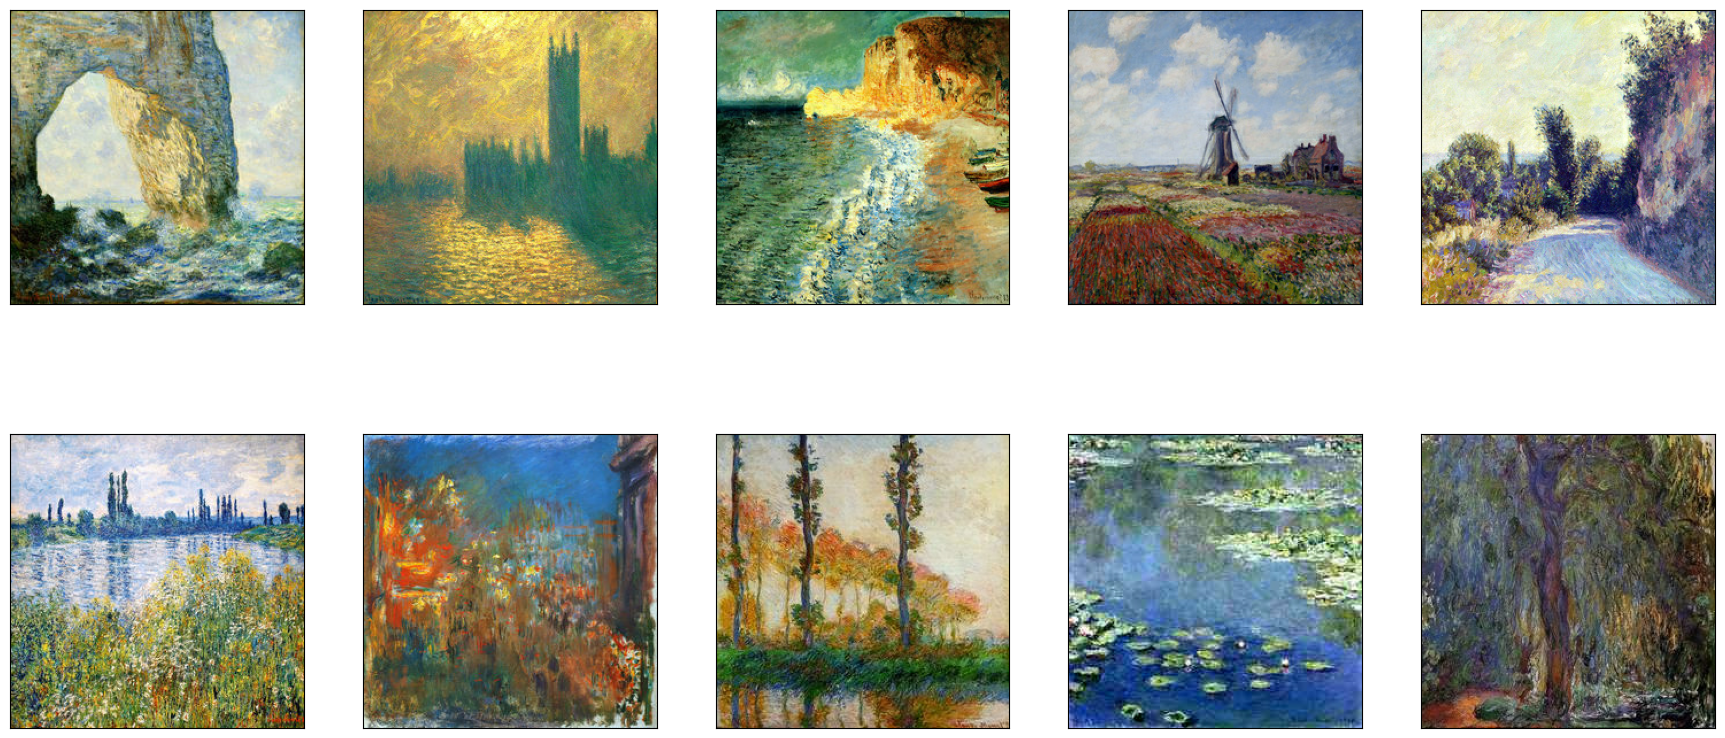

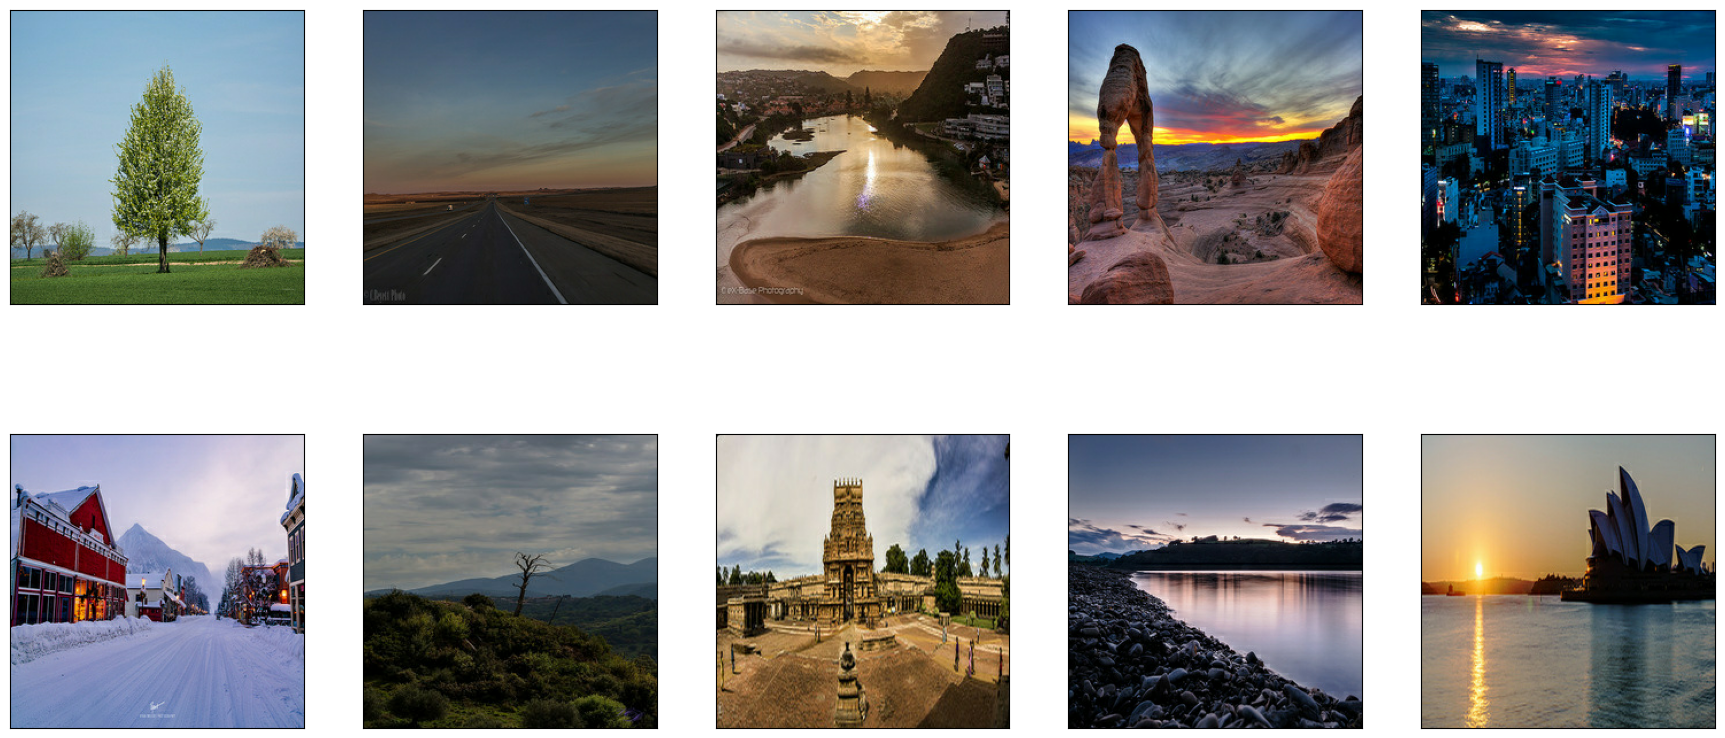

In [10]:
def view_image(ds, rows=2):
    image = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()

    fig = plt.figure(figsize=(22, rows * 5.05 ))
    for i in range(5 * rows):
        ax = fig.add_subplot(rows, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i] / 2 + .5)

view_image(monet_ds)
view_image(photo_ds)

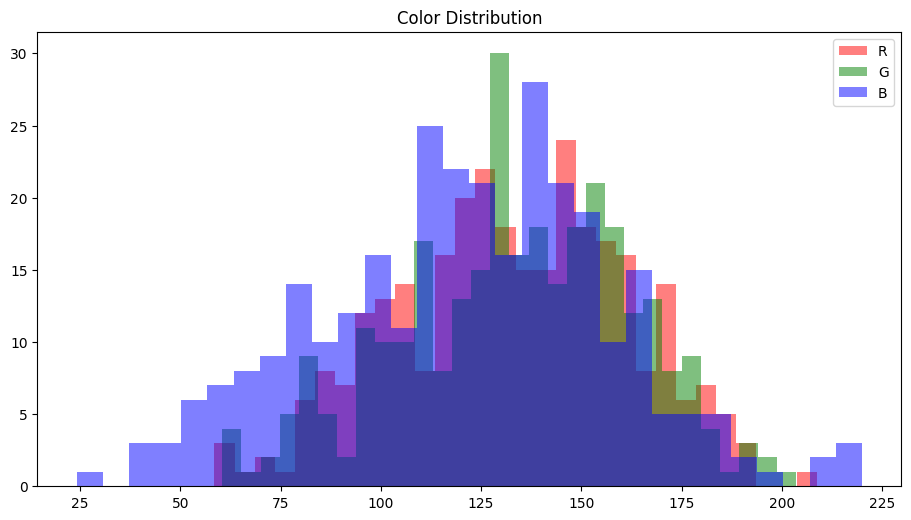

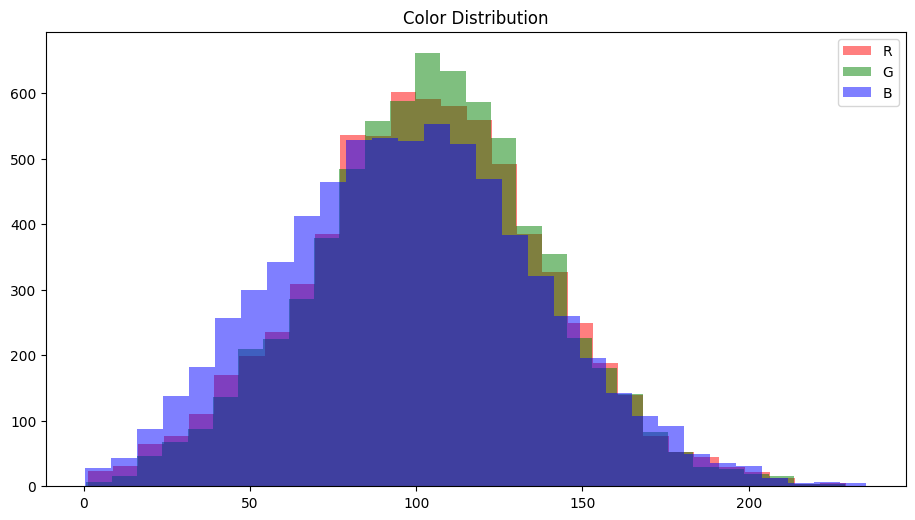

In [11]:
from PIL import Image
def analyze_images(directory):
    files = [f for f in os.listdir(directory) if f.lower().endswith(('jpg'))]
    color_distributions = []

    for file_name in files:
        file_path = os.path.join(directory, file_name)
        with Image.open(file_path) as img:
            color_distributions.append(np.array(img).mean(axis=(0, 1)))

    return color_distributions

def plot_analysis(color_distributions):    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 2, 1)
    color_distributions = np.array(color_distributions)
    if color_distributions.ndim == 2:
        plt.hist(color_distributions[:, 0], bins=30, color='red', alpha=0.5, label='R')
        plt.hist(color_distributions[:, 1], bins=30, color='green', alpha=0.5, label='G')
        plt.hist(color_distributions[:, 2], bins=30, color='blue', alpha=0.5, label='B')
        plt.legend()
        plt.title('Color Distribution')
    else:
        plt.hist(color_distributions, bins=30, color='gray', alpha=0.7)
        plt.title('Gray-scale Distribution')

    plt.tight_layout()
    plt.show()

color_distributions = analyze_images(monet_jpg_directory)
plot_analysis(color_distributions)

color_distributions = analyze_images(photo_jpg_directory)
plot_analysis(color_distributions)

In [12]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    result.add(layers.LeakyReLU())

    return result

In [13]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [14]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # hạ mẫu xuống thông qua mô hình
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # tăng mẫu và thiết lập các kết nối bỏ qua
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    leaky_relu = layers.LeakyReLU()(conv)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
with strategy.scope():
    monet_generator = Generator() # biến đổi ảnh thành tranh theo phong cách Monet
    photo_generator = Generator() # biến đổi các bức tranh của Monet thành giống ảnh chụp hơn

    monet_discriminator = Discriminator() # phân biệt tranh Monet thực sự và tranh Monet được tạo ra
    photo_discriminator = Discriminator() # phân biệt ảnh thật và ảnh được tạo ra

2024-12-01 17:03:01.473669: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself (tự tạo ra chính nó)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # bộ phân biệt được sử dụng để kiểm tra, nhập hình ảnh thực
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # bộ phân biệt dùng để kiểm tra, nhập hình ảnh giả
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # đánh giá tổn thất bộ tạo
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # đánh giá tổng thể sự tổn thất tính nhất quán của chu kỳ
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # đánh giá tổng tổn thất bộ tạo
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # đánh giá tổn thất phân biệt
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Tính toán gradients cho bộ tạo và bộ phân biệt
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Áp dụng các gradient cho trình tối ưu hóa
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [18]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [19]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [20]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [21]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [22]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [24]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


: 

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()